In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Loading the Data

In [2]:
import pandas as pd
import numpy as np

In [3]:
input_df = pd.read_csv('train.csv', header=0)
submission_df = pd.read_csv('test.csv', header=0)

In [4]:
df = pd.concat([input_df, submission_df])
''' Our index goes from 0 to len(input_df) and then again from 0 to len(submission_df). We want to reset this to 
    0 to (len(input_df) + len(submission_df))'''
df = df.reset_index() 
# this made a new row going from 0 to total len, and made a new column called index with original index values
df = df.drop('index', axis=1) # default axis=0 (looking in rows), axis=1 -> looking in columns
df = df.reindex_axis(input_df.columns, axis=1) # have df with the same column order as input_df

## Dealing with Missing Data

In [5]:
from sklearn.linear_model import LinearRegression

In [6]:
''' There are couple things we can do with missing values '''

# 1.) We can remove all the data with missing values, we cannot do that here because the dataset is small already

' There are couple things we can do with missing values '

In [7]:
# 2.) We can replace the null values with a value that indicates a missing value
df['Cabin'][df.Cabin.isnull()] = 'U0' # use .isnull() for string/ numerical features

C:\Users\mariamo\Anaconda\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [8]:
# 3.) Assign a common statistical value (mean, median, mode) to our variable
df['Fare'][df.Fare.isnull()] = df.Fare.dropna().median()
df['Embarked'][df.Embarked.isnull()] = df.Embarked.dropna().mode().values

C:\Users\mariamo\Anaconda\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
C:\Users\mariamo\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [9]:
# 4.) Use linear regression or other models to filling in the missing values

# We then need to convert categorical values to numerical in order to use for most classifiers
df['EmbarkedNum'] = pd.factorize(df.Embarked)[0] # [1] is the Index Key
df['Gender'] = pd.factorize(df.Sex)[0]

age_df = df[['Age', 'Gender', 'Pclass', 'SibSp', 'Parch', 'Fare', 'EmbarkedNum']]
knownAges = age_df[df.Age.notnull()]
unknownAges = age_df[df.Age.isnull()]
X_train = knownAges.values[:, 1::]
y_train = knownAges.values[:, 0]
X_test = unknownAges.values[:, 1::]

linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
y_pred = linearModel.predict(X_test)

df.Age[df.Age.isnull()] = y_pred

C:\Users\mariamo\Anaconda\lib\site-packages\IPython\kernel\__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
print df.info() # everything besides Survived should be 1309 non-null values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 14 columns):
PassengerId    1309 non-null int64
Survived       891 non-null float64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1309 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1309 non-null float64
Cabin          1309 non-null object
Embarked       1309 non-null object
EmbarkedNum    1309 non-null int32
Gender         1309 non-null int32
dtypes: float64(3), int32(2), int64(4), object(5)
memory usage: 143.2+ KB
None


## Variable Transformations

In [11]:
import re
from sklearn.preprocessing import StandardScaler

In [12]:
''' Transform Qualitative Variables '''

# 1.) Convert qualitative variables to dummy variables with binary values
dummies_df = pd.get_dummies(df.Embarked)
dummies_df = dummies_df.rename(columns=lambda x: 'Embarked_' + str(x))
df = pd.concat([df, dummies_df], axis=1)

In [13]:
# 2.) Convert qualitative variables to factorized numerical values
df['Deck'] = df.Cabin.map(lambda x: re.compile('([a-zA-Z]+)').search(x).group())
df.Deck = pd.factorize(df.Deck)[0] # create numerical values
dummies_df = pd.get_dummies(df.Deck)
dummies_df = dummies_df.rename(columns=lambda x: 'Deck_' + str(x)) # create a binary dummy variable for each Deck as well
dummies_df = pd.concat([df, dummies_df], axis=1)

In [14]:
''' Transform Quantitative Variables '''
# 1.) Scale the numerical values to have mean: 0 and var: 1
scaler = StandardScaler()
df['Age_scaled'] = scaler.fit_transform(df.Age)

In [15]:
# 2.) Seprate the numerical values into distinct quartiles
df['Age_quart'] = pd.qcut(df.Age, 4)
df['Age_quart_Num'] = pd.factorize(df.Age_quart)[0] # create factorized values

df['Fare_quart'] = pd.qcut(df.Fare, 4)
df['Fare_quart_Num'] = pd.factorize(df.Fare_quart)[0] # create factorized values
dummies_df = pd.get_dummies(df.Fare_quart_Num) # and we can also create dummy variables from the quartiles
dummies_df = dummies_df.rename(columns=lambda x: 'Fare_' + str(x))
df = pd.concat([df, dummies_df], axis=1)

In [16]:
print df.columns

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked',
       u'EmbarkedNum', u'Gender', u'Embarked_C', u'Embarked_Q', u'Embarked_S',
       u'Deck', u'Age_scaled', u'Age_quart', u'Age_quart_Num', u'Fare_quart',
       u'Fare_quart_Num', u'Fare_0', u'Fare_1', u'Fare_2', u'Fare_3'],
      dtype='object')


## Feature Engineering

In [17]:
''' Name '''

# The length of their name (title, first, middle, last, position) may relate to their status and so they might get a lifeboat
df['NameLen'] = df.Name.map(lambda x: len(re.split(' ', x)))

In [18]:
# The title of their name can also give insight into their status
df['Title'] = df.Name.map(lambda x: re.compile(", (.*?)\.").findall(x)[0])
df.Title[df.Title.isin(['Capt', 'Col', 'Don', 'Major', 'Sir'])] = 'Sir'
df.Title[df.Title.isin(['Dona', 'Lady', 'the Countess'])] = 'Lady'
df.Title[df.Title.isin(['Ms','Mlle'])] = 'Miss'
df.Title[df.Title == 'Jonkheer'] = 'Master'
df.Title[df.Title == 'Mme'] = 'Mrs'

# We can built binary features from this too
dummies_df = pd.get_dummies(df.Title)
dummies_df = dummies_df.rename(columns=lambda x: 'Title_' + str(x))
df = pd.concat([df, dummies_df], axis=1)

C:\Users\mariamo\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\mariamo\Anaconda\lib\site-packages\IPython\kernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\mariamo\Anaconda\lib\site-packages\IPython\kernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\mariamo\Anaconda\lib\site-packages\IPython\kernel\__main__.py:6: SettingWithCopyWarning

In [19]:
''' Family '''

# We can rougly estimate the number of members in the family by SibSp + Parch + 1
df["Family_size"] = df.SibSp + df.Parch + 1

In [20]:
''' Cabin '''

# We have already created numerical and dummy variables for Deck above

# We can also use the room number from Cabin to determine location on ship
def getRoomNum(Cabin):
    match = re.compile("([0-9]+)").search(Cabin)
    if match:
        return match.group()
    else:
        return 0

df['Room'] = df.Cabin.map(lambda x: getRoomNum(x))

In [21]:
''' Ticket '''

# Most Tickets have a prefix and a number
def getTicketPrefix(ticket):
    match = re.compile("([a-zA-Z\.\/]+)").search(ticket) # gets the alphabetical ID from ticket until space or /
    if match:
        return match.group()
    else: # ticket is all numbers
        return 'U'

def getTicketNumber(ticket):
    match = re.compile("([\d]+$)").search(ticket)
    if match:
        return match.group()
    else:
        return '0'
    
df['TicketPrefix'] = df['Ticket'].map( lambda x : getTicketPrefix(x.upper()))
df['TicketPrefix'] = df['TicketPrefix'].map( lambda x: re.sub('[\.?\/?]', '', x)) # remove useless "/"
df['TicketPrefix'] = df['TicketPrefix'].map( lambda x: re.sub('STON', 'SOTON', x)) # replace STON with SOTON (more uniformity)
dummies_df = pd.get_dummies(df.TicketPrefix) # make dummy variables
dummies_df = dummies_df.rename(columns=lambda x: 'TicketPrefix_' + str(x))
df = pd.concat([df, dummies_df], axis=1)
df['TicketPrefixNum'] = pd.factorize(df.TicketPrefix)[0] # create numerical values as well

df['TicketNumber'] = df.Ticket.map(lambda x: getTicketNumber(x))
df['TicketNumLen'] = df.TicketNumber.map(lambda x: len(x)).astype(np.int)
df['TicketFirstNum'] = df.TicketNumber.map(lambda x: x[0:1]).astype(np.int)

## Interaction Variables

In [22]:
# We want to scale a few of our features to generate interaction features

df['Fare_scaled'] = scaler.fit_transform(df.Fare)
df['Pclass_scaled'] = scaler.fit_transform(df.Pclass)
df['Parch_scaled'] = scaler.fit_transform(df.Parch)
df['SibSp_scaled'] = scaler.fit_transform(df.SibSp)
df['Names_scaled'] = scaler.fit_transform(df.NameLen)
df['CabinNumber_scaled'] = scaler.fit_transform(df.Room)
df['Age_quart_Num_scaled'] = scaler.fit_transform(df.Age_quart_Num)
df['Fare_quart_Num_scaled'] = scaler.fit_transform(df.Fare_quart_Num)

C:\Users\mariamo\Anaconda\lib\site-packages\sklearn\utils\validation.py:498: UserWarning: StandardScaler assumes floating point values as input, got int64
  "got %s" % (estimator, X.dtype))
C:\Users\mariamo\Anaconda\lib\site-packages\sklearn\utils\validation.py:498: UserWarning: StandardScaler assumes floating point values as input, got int32
  "got %s" % (estimator, X.dtype))


In [23]:
''' Now we want to see if there are relationships between our variables. We have scaled them, so now we want to see if +-*/ 
    can add to our model. We could also try ln, trig functions, sqrt and other methods with more than two features '''

numerics = df.loc[:, ['Age_scaled', 'Fare_scaled', 'Pclass_scaled', 'Parch_scaled', 'SibSp_scaled', 
                      'Names_scaled', 'CabinNumber_scaled', 'Age_quart_Num_scaled', 'Fare_quart_Num_scaled']]

for i in range(len(numerics.columns)):
    for j in range(len(numerics.columns)):
        col1 = numerics.columns[i]
        col2 = numerics.columns[j]
        if i <= j: # multiply same and different fields
            name = col1 + '*' + col2
            df = pd.concat([df, pd.Series(numerics.iloc[:, i] * numerics.iloc[:, j], name=name)], axis=1)
        if i < j: # add different fields together
            name = col1 + '+' + col2
            df = pd.concat([df, pd.Series(numerics.iloc[:, i] + numerics.iloc[:, j], name=name)], axis=1)
        if not i == j: # divide and subtract fields from other fields
            name = col1 + '/' + col2
            df = pd.concat([df, pd.Series(numerics.iloc[:, i] / numerics.iloc[:, j], name=name)], axis=1)
            name = col1 + '-' + col2
            df = pd.concat([df, pd.Series(numerics.iloc[:, i] - numerics.iloc[:, j], name=name)], axis=1)

In [24]:
''' All of this feature generation created variables that may be highly corelated with the one of the original variables or 
    with one of the new interaction variables. This creates a multicolinearity problem which becomes an issue for linear models.
    It is always a good idea to remove them, regardless of your model type, in order to improve performance. We can decide which
    variables to remove by using correlations such as Spearman or Pearson'''

# First, we only want to deal with numerical data now so we can make a new df
df = df.select_dtypes(include=[np.number]) # only keeps columns with numerical data
df_corr = df.drop(['Survived', 'PassengerId'], axis=1).corr(method='spearman')

In [25]:
# Obviously variables will be highly correlated with each other, so we will replace them with 0
mask = np.ones(len(df_corr)) - np.eye(len(df_corr))
df_corr = mask * df_corr

In [27]:
# We can find correlations greater than 0.98 and drop those features
drops = []
for col in df_corr.columns.values:
    
    if np.in1d([col], drops):
        continue # go to next col, this col is already in drops list
    corr = df_corr[abs(df_corr[col]) > 0.98].index
    drops = np.union1d(drops, corr)
    
print 'We are dropped %d highly correlated features: ' % len(drops)
print drops

df = df.drop(drops, axis=1)

We are dropped 49 highly correlated features: 
['Age_quart_Num_scaled' 'Age_quart_Num_scaled-Age_scaled'
 'Age_quart_Num_scaled-CabinNumber_scaled'
 'Age_quart_Num_scaled-Fare_scaled' 'Age_quart_Num_scaled-Names_scaled'
 'Age_quart_Num_scaled-Parch_scaled' 'Age_quart_Num_scaled-Pclass_scaled'
 'Age_quart_Num_scaled-SibSp_scaled' 'Age_scaled'
 'Age_scaled/Age_quart_Num_scaled' 'CabinNumber_scaled-Age_scaled'
 'CabinNumber_scaled-Fare_scaled' 'CabinNumber_scaled-Names_scaled'
 'CabinNumber_scaled-Parch_scaled' 'CabinNumber_scaled-Pclass_scaled'
 'CabinNumber_scaled-SibSp_scaled' 'Embarked_S' 'Fare_quart_Num_scaled'
 'Fare_quart_Num_scaled-Age_quart_Num_scaled'
 'Fare_quart_Num_scaled-Age_scaled'
 'Fare_quart_Num_scaled-CabinNumber_scaled'
 'Fare_quart_Num_scaled-Fare_scaled' 'Fare_quart_Num_scaled-Names_scaled'
 'Fare_quart_Num_scaled-Parch_scaled' 'Fare_quart_Num_scaled-Pclass_scaled'
 'Fare_quart_Num_scaled-SibSp_scaled' 'Fare_scaled'
 'Fare_scaled-Age_scaled' 'Names_scaled' 'Names_sca

ValueError: labels ['Age_quart_Num_scaled' 'Age_quart_Num_scaled-Age_scaled'
 'Age_quart_Num_scaled-CabinNumber_scaled'
 'Age_quart_Num_scaled-Fare_scaled' 'Age_quart_Num_scaled-Names_scaled'
 'Age_quart_Num_scaled-Parch_scaled' 'Age_quart_Num_scaled-Pclass_scaled'
 'Age_quart_Num_scaled-SibSp_scaled' 'Age_scaled'
 'Age_scaled/Age_quart_Num_scaled' 'CabinNumber_scaled-Age_scaled'
 'CabinNumber_scaled-Fare_scaled' 'CabinNumber_scaled-Names_scaled'
 'CabinNumber_scaled-Parch_scaled' 'CabinNumber_scaled-Pclass_scaled'
 'CabinNumber_scaled-SibSp_scaled' 'Embarked_S' 'Fare_quart_Num_scaled'
 'Fare_quart_Num_scaled-Age_quart_Num_scaled'
 'Fare_quart_Num_scaled-Age_scaled'
 'Fare_quart_Num_scaled-CabinNumber_scaled'
 'Fare_quart_Num_scaled-Fare_scaled' 'Fare_quart_Num_scaled-Names_scaled'
 'Fare_quart_Num_scaled-Parch_scaled' 'Fare_quart_Num_scaled-Pclass_scaled'
 'Fare_quart_Num_scaled-SibSp_scaled' 'Fare_scaled'
 'Fare_scaled-Age_scaled' 'Names_scaled' 'Names_scaled-Age_scaled'
 'Names_scaled-Fare_scaled' 'Names_scaled-Parch_scaled'
 'Names_scaled-Pclass_scaled' 'Names_scaled-SibSp_scaled' 'Parch_scaled'
 'Parch_scaled*Parch_scaled' 'Parch_scaled+SibSp_scaled'
 'Parch_scaled-Age_scaled' 'Parch_scaled-Fare_scaled'
 'Parch_scaled-Pclass_scaled' 'Pclass_scaled' 'Pclass_scaled-Age_scaled'
 'Pclass_scaled-Fare_scaled' 'SibSp_scaled' 'SibSp_scaled*SibSp_scaled'
 'SibSp_scaled-Age_scaled' 'SibSp_scaled-Fare_scaled'
 'SibSp_scaled-Parch_scaled' 'SibSp_scaled-Pclass_scaled'] not contained in axis

## Dimensionality Reduction

In [28]:
from sklearn.decomposition import PCA

In [29]:
pca = PCA(n_components=0.99) # the variance percent we want to maintain
X = df.drop(['PassengerId', 'Survived'], axis=1).values
X_transformed = pca.fit_transform(X)
print 'We transformed %i into %i while maintaining %f of the variance' % (len(X[0]), len(X_transformed[0]), 0.99)
pcaDataFrame = pd.DataFrame(X_transformed)

We transformed 244 into 39 while maintaining 0.990000 of the variance


## Random Forest Classifier

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
forest = RandomForestClassifier(oob_score=True, n_estimators=10000)
forest.fit(X_transformed[:len(input_df),:], input_df['Survived'].values)
feature_importance = forest.feature_importances_

In [32]:
feature_importance = 100.0 * (feature_importance / feature_importance.max())
important_points = df.drop(['Survived', 'PassengerId'], axis=1)
features_list = important_points.columns

feature_threshold = 50 # feature importance to exceed
important_index = np.where(feature_importance > feature_threshold)[0]
important_features = features_list[important_index]
sorted_index = np.argsort(feature_importance[important_index])[::-1]
print "\nOrdered Features by Importance:\n", important_features[sorted_index]


Ordered Features by Importance:
Index([u'Age', u'Pclass', u'Title_Mrs', u'Title_Dr', u'Fare_0', u'Title_Lady',
       u'Title_Rev', u'TicketPrefix_AQ', u'TicketPrefix_AS', u'Deck',
       u'Title_Sir', u'EmbarkedNum', u'TicketPrefix_LINE', u'TicketPrefix_PC'],
      dtype='object')


## Hyperparameter Optimization

In [33]:
from sklearn.grid_search import RandomizedSearchCV

In [34]:
X = X_transformed[:len(input_df),:]
y = input_df['Survived'].values

In [35]:
sqrtfeat = np.sqrt(X.shape[1]) # default max number of features
random_test2 = { "n_estimators"      : np.rint(np.linspace(X.shape[0]*2, X.shape[0]*4, 5)).astype(int), # number of trees
                 "criterion"         : ["gini", "entropy"],
                 "max_features"      : np.rint(np.linspace(sqrtfeat/2, sqrtfeat*2, 5)).astype(int),
                 "min_samples_split" : np.rint(np.linspace(2, X.shape[0]/50, 5)).astype(int),
                 "min_samples_leaf"  : np.rint(np.linspace(1, X.shape[0]/100, 5)).astype(int)}

forest = RandomForestClassifier(oob_score=True)
grid_search = RandomizedSearchCV(forest, random_test2, n_jobs=1, cv=4, n_iter=5)
grid_search.fit(X, y)              

RandomizedSearchCV(cv=4, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'n_estimators': array([1782, 2228, 2673, 3118, 3564]), 'max_features': array([ 3,  5,  8, 10, 12]), 'min_samples_split': array([ 2,  6, 10, 13, 17]), 'criterion': ['gini', 'entropy'], 'min_samples_leaf': array([1, 3, 4, 6, 8])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring=None, verbose=0)

In [36]:
def reportScores(gridScores, numberOfScores=5):
    topScores = sorted(gridScores, key=lambda x: x[1], reverse=True)[0:numberOfScores]
    for i, score in enumerate(topScores):
        print "%i Best Run" % (int(i)+1)
        print "Mean Validation Score: %f, std: %f" % (score.mean_validation_score, np.std(score.cv_validation_scores))
        print "Parameters: ", score.parameters 
    return score.parameters
best_params_from_rand_search2 = reportScores(grid_search.grid_scores_)     

1 Best Run
Mean Validation Score: 0.750842, std: 0.040463
Parameters:  {'max_features': 8, 'min_samples_split': 13, 'n_estimators': 1782, 'criterion': 'gini', 'min_samples_leaf': 4}
2 Best Run
Mean Validation Score: 0.748597, std: 0.039765
Parameters:  {'max_features': 10, 'min_samples_split': 10, 'n_estimators': 3564, 'criterion': 'gini', 'min_samples_leaf': 4}
3 Best Run
Mean Validation Score: 0.747475, std: 0.034991
Parameters:  {'max_features': 3, 'min_samples_split': 10, 'n_estimators': 3118, 'criterion': 'entropy', 'min_samples_leaf': 8}
4 Best Run
Mean Validation Score: 0.747475, std: 0.037438
Parameters:  {'max_features': 3, 'min_samples_split': 2, 'n_estimators': 2228, 'criterion': 'entropy', 'min_samples_leaf': 8}
5 Best Run
Mean Validation Score: 0.742985, std: 0.030187
Parameters:  {'max_features': 5, 'min_samples_split': 13, 'n_estimators': 1782, 'criterion': 'entropy', 'min_samples_leaf': 1}


## Bias-Variance Tradeoff

In [37]:
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve

In [38]:
train_sizes, train_scores, test_scores = learning_curve(
        grid_search, X, y, cv=3, n_jobs=1, train_sizes=np.linspace(.1, 1., 5), verbose=0)
 
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

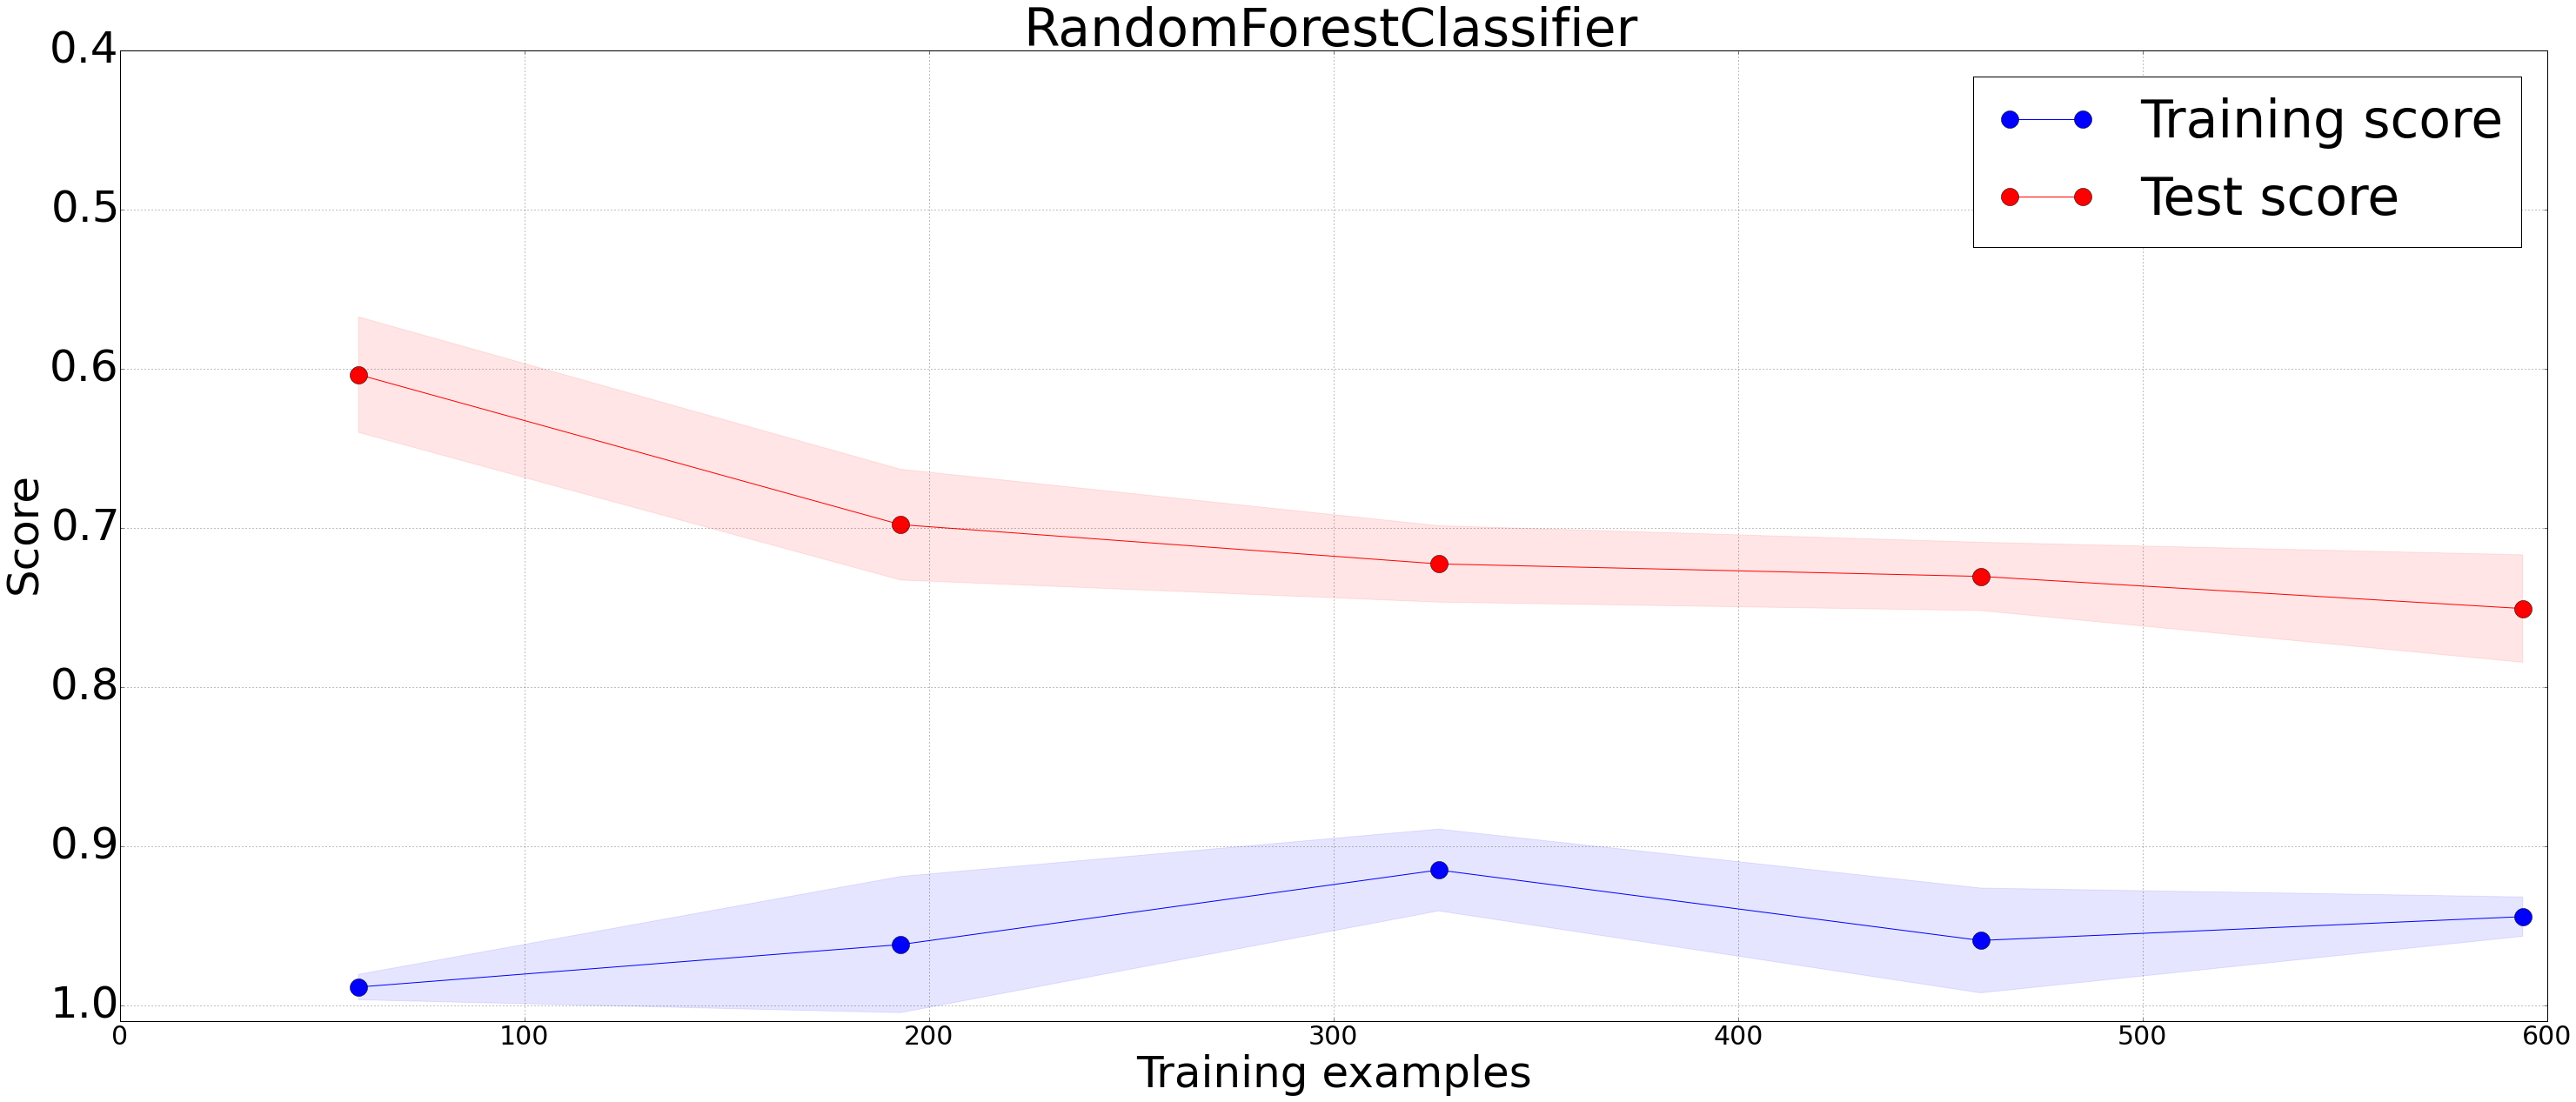

In [40]:
plt.figure(figsize=(50, 20))
plt.title("RandomForestClassifier", fontsize = 60)
plt.xlabel("Training examples", fontsize = 50)
plt.ylabel("Score", fontsize = 50)
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=50)
plt.ylim((0.4, 1.01))
plt.gca().invert_yaxis()
plt.grid()
 
# For each training set size, we plot the train and test scores
plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training score", markersize=20)
plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label="Test score", markersize=20)
plt.legend(loc="upper right", prop={'size':60}) 
    
# For each training set size, we plot the range of values of the mean
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                 alpha=0.1, color="b")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                 alpha=0.1, color="r")
plt.show()

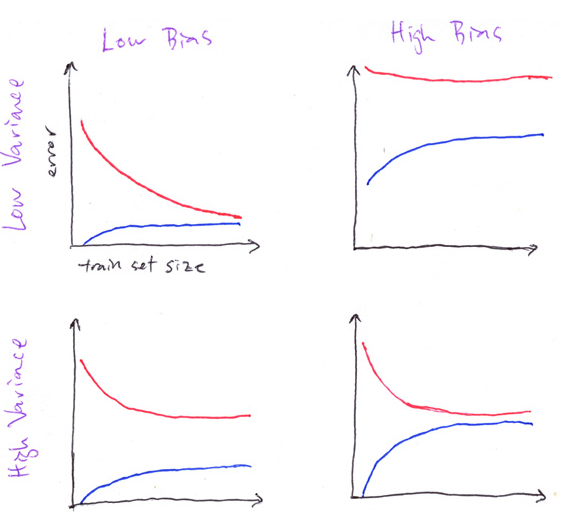

In [94]:
''' Our graph displays high variance and low bias (overfitting). To decrease the high variance, we can do three things. We can
    further regularize our model to avoid overfitting the training set. We can also decrease the number of features, and keep
    only the most useful. Lastly, we can use more training samples to decrease the test error rate. If none of these techniques
    yield the result we want, then we must try move advanced models (Gradient Boosting Machines (GBM) or Artificial Neural
    Networks (ANN)) '''
from IPython.display import Image
Image(filename='bv.png') # Courtesy of Professor Andrew Ng from Stanford University

## AUC/ROC Curves

In [110]:
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
forest.fit(X_train, y_train)

C:\Users\mariamo\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:379: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

Area under the Curve: 0.756790018673


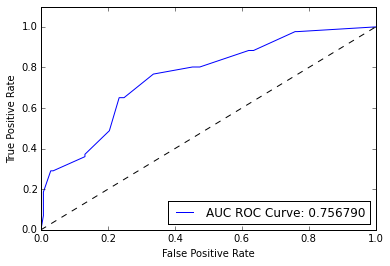

' We want our AUC to be high and for the graph to pinch the upper left. We need to do some remodeling to achieve this'

In [141]:
fpr, tpr, waste = roc_curve(y_test, forest.predict_proba(X_test)[:,1]) # probability of 1
roc_auc = auc(fpr, tpr)
print 'Area under the Curve:', roc_auc
plt.figure()
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label="AUC ROC Curve: %f" %roc_auc)
plt.legend(loc="lower right", prop={'size':12}) 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0, 1])
plt.ylim([0, 1.1]) # so we can see the end of the curve
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)
plt.show() 
' We want our AUC to be high and for the graph to pinch the upper left. We need to do some remodeling to achieve this'

## Submission File

In [59]:
y_pred = grid_search.predict(X_transformed[len(input_df):, :])
ids = submission_df['PassengerId'].values

In [60]:
import csv as csv
predictions_file = open("submission.csv", "wb")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["PassengerId","Survived"])
open_file_object.writerows(zip(ids, y_pred))
predictions_file.close()

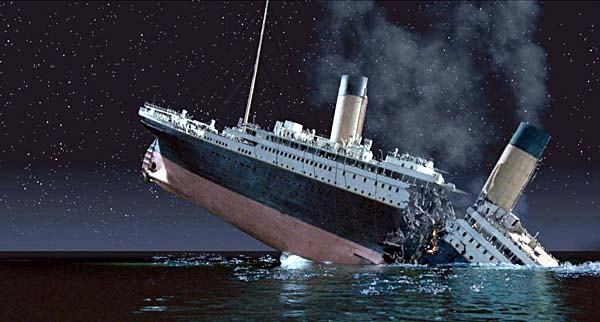

In [143]:
from IPython.display import Image
Image(filename='titanic-sinking.jpg')